In [3]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras import backend as K
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os

컬러 이미지의 흑백 변환
grayscale = 0.299*red + 0.587*green + 0.114*blue

In [4]:
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [5]:
(x_train, _), (x_test, _) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [6]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [7]:
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

AttributeError: ignored

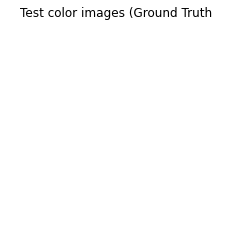

In [9]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
img = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth')
plt.imshow(imgs, interpolarion='none', cmap='gray')
plt.savefig('%s/test_color.pnt'%imgs_dir)
plt.show()

In [10]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

AttributeError: ignored

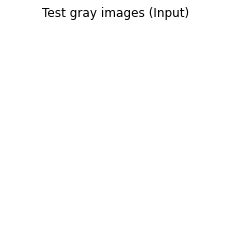

In [11]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolarion='none', cmap='gray')
plt.savefig('$s/test_gray.pnt'%imgs_dir)
plt.show()

In [12]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [13]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [14]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [16]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [17]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

In [18]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
  x = Conv2D(filters = filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

In [19]:
shape = K.int_shape(x)

In [20]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [21]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [22]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [23]:
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

In [25]:
output = Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same', name='decoder_output')(x)

In [28]:
decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

In [29]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [30]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [32]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)

In [33]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)

In [34]:
autoencoder.compile(loss='mse', optimizer='adam')

In [38]:
callbacks = [lr_reducer, checkpoint]

In [39]:
autoencoder.fit(x_train_gray, x_train, validation_data=(x_test_gray, x_test), epochs=30, batch_size=batch_size, callbacks=callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0153
Epoch 1: val_loss improved from inf to 0.01108, saving model to /content/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 577s 369ms/step - loss: 0.0153 - val_loss: 0.0111 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0101
Epoch 2: val_loss improved from 0.01108 to 0.00957, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 576s 369ms/step - loss: 0.0101 - val_loss: 0.0096 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0091
Epoch 3: val_loss improved from 0.00957 to 0.00886, saving model to /content/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 576s 368ms/step - loss: 0.0091 - val_loss: 0.0089 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0085
Epoch 4: val_los

In [40]:
x_decoded = autoencoder.predict(x_test_gray)

313/313 [==============================] - 47s 149ms/step
